In [163]:
import pydicom as dicom
import matplotlib.pylab as plt
import numpy as np
import os
import skimage as ski
from skimage.transform import warp, AffineTransform, pyramid_expand, pyramid_reduce
import cv2
import scipy
import pywt
import numpy as np

from natsort import natsorted
from scipy.optimize import dual_annealing,basinhopping
# from sklearn.mixture import GaussianMixture
from skimage.registration import phase_cross_correlation
from scipy import ndimage as scp
from tqdm import tqdm
from skimage.metrics import normalized_root_mse as nrm
# from statsmodels.tsa.stattools import acf
import pickle
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
from scipy.fftpack import fft2, fftshift, ifft2, fft, ifft
from skimage.exposure import match_histograms
import time
import math
from skimage.exposure import equalize_hist
from skimage.exposure import equalize_adapthist
# from skimage.feature import SIFT, match_descriptors,plot_matches
# from skimage.feature import ORB
import ants.registration as ants_register
import ants
from scipy.optimize import minimize as minz
from scipy import optimize
import pickle
from skimage.filters import threshold_otsu
from skimage.metrics import normalized_mutual_information as nmi
from skimage.metrics import mean_squared_error as mse
from tifffile import imread as tiffread
import sys
from util_funcs import *

In [313]:

def ants_all_trans(data,UP,DOWN):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(data.shape[0]-1),desc='tr_all'):
        temp_img = data[i+1][UP:DOWN].copy()
        # PHASE
        coords = phase_cross_correlation(min_max(data[i][UP:DOWN][:,:])
                                        ,min_max(temp_img[:,:])
                                        ,normalization=None,upsample_factor=20)[0]
        if np.abs(coords[0])<=30:
            temp_img = warp(temp_img,AffineTransform(translation = (0,-coords[0])),order=3)
            tff = AffineTransform(translation = (0,-coords[0]))
            transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

        # # ANTS
        # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN][:,:]),min_max(temp_img[:,:]))[0])
        # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN]),min_max(data[i+1][UP:DOWN]))[0])
        # if np.abs(mat['AffineTransform_float_2_2'][-2:][0][0])<=1000:
        #     tff = AffineTransform(translation = (0,mat['AffineTransform_float_2_2'][-2:][0][0]))
        #     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)
    return transforms_all


# 5woWT

In [3]:
scan_num = '5woWT'
path = f'{scan_num}/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pics_without_line = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pics_without_line[i] = dicom.dcmread(path+j).pixel_array
pics_without_line = pics_without_line.astype(np.float32)

500it [00:06, 79.13it/s]


In [4]:
pics_without_line = pics_without_line[:,np.r_[1200:2200,6000:6900]]

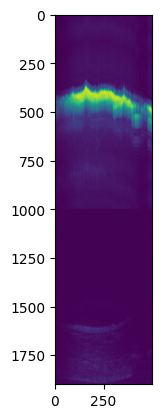

In [5]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [6]:
mid = 1000
UP,DOWN = 250,600
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:07<00:00, 66.41it/s]


In [7]:
# n = pics_without_line.shape[1]
# # nn = [np.argmax(np.sum(pics_without_line[i][:n//2],axis=1)) for i in range(pics_without_line.shape[0])]
# nn = [np.argmax(np.sum(pics_without_line[i][500:800],axis=1)) for i in range(pics_without_line.shape[0])]
# mid = 1000
# tf_all_nn = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
# for i in range(tf_all_nn.shape[0]):
#     tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
# for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
#     pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tf_all_nn[i]),order=3)

In [8]:
mid = 1000
UP,DOWN = 1500,1700
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:07<00:00, 71.43it/s]


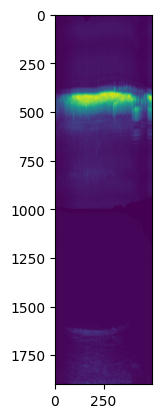

In [9]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [10]:
# nn = [np.argmax(np.sum(pics_without_line[i][1500:1700],axis=1)) for i in range(pics_without_line.shape[0])]
# mid = 1000
# tf_all_nn = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
# for i in range(tf_all_nn.shape[0]):
#     tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
# for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
#     pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tf_all_nn[i]),order=3)

In [11]:
# plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))
# nn = [np.argmax(np.sum(pics_without_line[i][:n//2],axis=1)) for i in range(pics_without_line.shape[0])]
# UP, DOWN = np.min(nn)-80,np.max(nn)+80

In [12]:
# tr_all = ants_all_trans(pics_without_line,UP,DOWN)
# for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
#     pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

In [13]:
# plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0)[1500:1700])

In [14]:
os.makedirs(f'registered/{scan_num}',exist_ok=True)
for i,j in tqdm(enumerate(pics_without_line)):
    cv2.imwrite(f'registered/{scan_num}/'+f'frame_test{i}.PNG',(min_max(j)*((2**16)-1)).astype(np.uint16))

500it [00:09, 50.16it/s]


# 5woFECD

In [15]:
scan_num = '5woFECD'
path = f'{scan_num}/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pics_without_line = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pics_without_line[i] = dicom.dcmread(path+j).pixel_array
pics_without_line = pics_without_line.astype(np.float32)

500it [00:02, 206.28it/s]


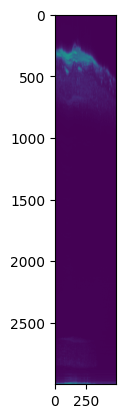

In [16]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [17]:
pics_without_line = pics_without_line[:,np.r_[:1000,2500:2900]]

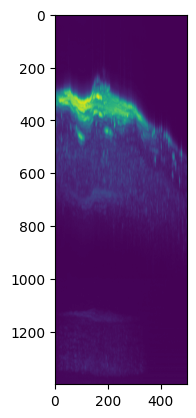

In [18]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [19]:
mid = 800
UP,DOWN = 200,600
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:05<00:00, 85.56it/s]


In [20]:
# n = pics_without_line.shape[1]
# # nn = [np.argmax(np.sum(pics_without_line[i][:n//2],axis=1)) for i in range(pics_without_line.shape[0])]
# nn = [np.argmax(np.sum(pics_without_line[i][200:600],axis=1)) for i in range(pics_without_line.shape[0])]
# mid = 800
# tf_all_nn = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
# for i in range(tf_all_nn.shape[0]):
#     tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
# for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
#     pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tf_all_nn[i]),order=3)

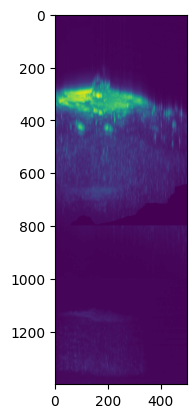

In [21]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [22]:
# nn = [np.argmax(np.sum(pics_without_line[i][1000:1250],axis=1)) for i in range(pics_without_line.shape[0])]
# mid = 800
# tf_all_nn = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
# for i in range(tf_all_nn.shape[0]):
#     tf_all_nn[i] = np.dot(tf_all_nn[i],AffineTransform(translation=(0,-(nn[0]-nn[i]))))
# for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
#     pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tf_all_nn[i]),order=3)

mid = 800
UP,DOWN = 1000,1250
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:04<00:00, 121.42it/s]


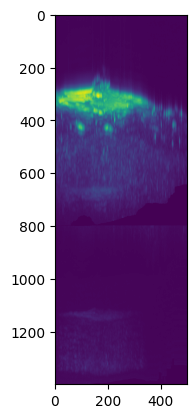

In [23]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [24]:
os.makedirs(f'registered/{scan_num}',exist_ok=True)
for i,j in tqdm(enumerate(pics_without_line)):
    cv2.imwrite(f'registered/{scan_num}/'+f'frame_test{i}.PNG',(min_max(j)*((2**16)-1)).astype(np.uint16))

500it [00:06, 71.96it/s]


# 16woWT

In [25]:
scan_num = '16woWT'
path = f'{scan_num}/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pics_without_line = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pics_without_line[i] = dicom.dcmread(path+j).pixel_array
pics_without_line = pics_without_line.astype(np.float32)

500it [00:01, 250.43it/s]


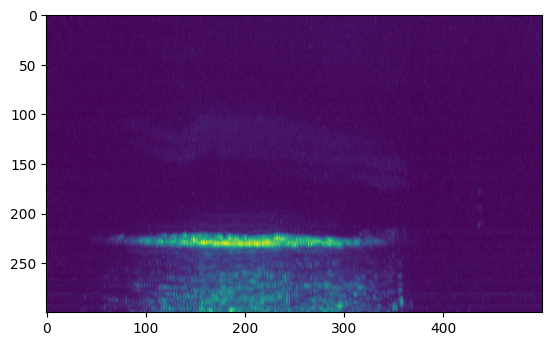

In [26]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0)[2100:2400])

In [27]:
pics_without_line = pics_without_line[:,np.r_[250:750,2100:2400]]

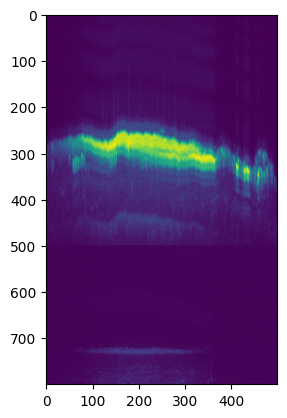

In [28]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [29]:
mid = 500
UP,DOWN = 200,420
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:03<00:00, 148.47it/s]


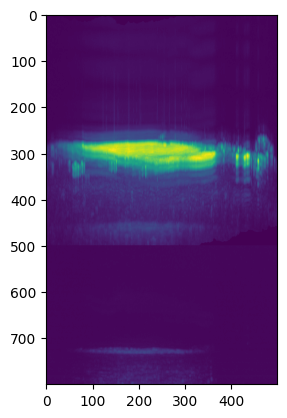

In [30]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [31]:
mid = 500
UP,DOWN = 650,800
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:02<00:00, 248.55it/s]


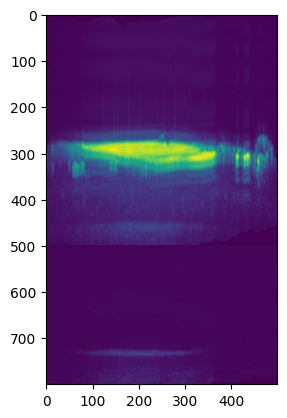

In [32]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [33]:
os.makedirs(f'registered/{scan_num}',exist_ok=True)
for i,j in tqdm(enumerate(pics_without_line)):
    cv2.imwrite(f'registered/{scan_num}/'+f'frame_test{i}.PNG',(min_max(j)*((2**16)-1)).astype(np.uint16))

500it [00:03, 129.40it/s]


# 16woFECD

In [34]:
scan_num = '16woFECD'
path = f'{scan_num}/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pics_without_line = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pics_without_line[i] = dicom.dcmread(path+j).pixel_array
pics_without_line = pics_without_line.astype(np.float32)

500it [00:01, 259.45it/s]


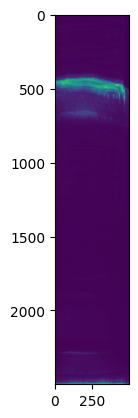

In [35]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [36]:
pics_without_line = pics_without_line[:,np.r_[200:900,2100:2400]]

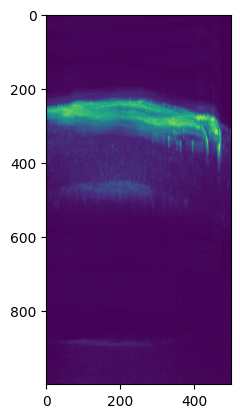

In [37]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [38]:
mid = 600
UP,DOWN = 190,420
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:04<00:00, 122.61it/s]


In [39]:
mid = 600
UP,DOWN = 800,1000
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:02<00:00, 183.63it/s]


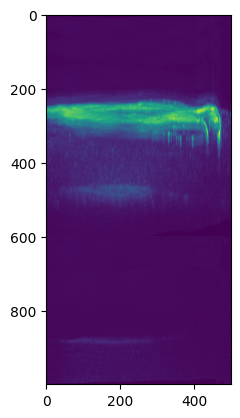

In [40]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [41]:
os.makedirs(f'registered/{scan_num}',exist_ok=True)
for i,j in tqdm(enumerate(pics_without_line)):
    cv2.imwrite(f'registered/{scan_num}/'+f'frame_test{i}.PNG',(min_max(j)*((2**16)-1)).astype(np.uint16))

500it [00:04, 106.43it/s]


# scan33

In [104]:
scan_num = 'scan33_ircard'
path = f'{scan_num}/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pics_without_line = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pics_without_line[i] = dicom.dcmread(path+j).pixel_array
pics_without_line = pics_without_line.astype(np.float32)

500it [00:01, 425.61it/s]


In [105]:
def ants_reg_mapping(stat,mov):
    ants1 = ants.from_numpy(stat.astype(np.float32))
    ants2 = ants.from_numpy(mov.astype(np.float32))
    reg = ants_register(ants1,ants2,type_of_transform = 'Translation',
                        aff_iterations=(1100, 1200, 500, 500))
    return reg['fwdtransforms']

def ants_all_trans(data,UP,DOWN):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(data.shape[0]-1),desc='tr_all'):
        temp_img = data[i+1].copy()
        # PHASE
        coords = phase_cross_correlation((data[i])
                                        ,(temp_img)
                                        ,normalization=None,upsample_factor=15)[0]
        if np.abs(coords[0])<=5:
            # temp_img = warp(temp_img,AffineTransform(translation = (0,-coords[0])),order=0)
            tff = AffineTransform(translation = (0,-coords[0]))
            transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

        # ANTS
        # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN][:,:50]),min_max(temp_img[:,:50]))[0])
        # # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN]),min_max(data[i+1][UP:DOWN]))[0])
        # if np.abs(mat['AffineTransform_float_2_2'][-2:][0][0])<=5:
        #     tff = AffineTransform(translation = (0,mat['AffineTransform_float_2_2'][-2:][0][0]))
        #     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)
    return transforms_all


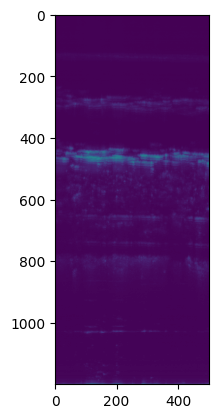

In [106]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [107]:
mid = 1000
UP,DOWN = 0,0
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:07<00:00, 70.54it/s]


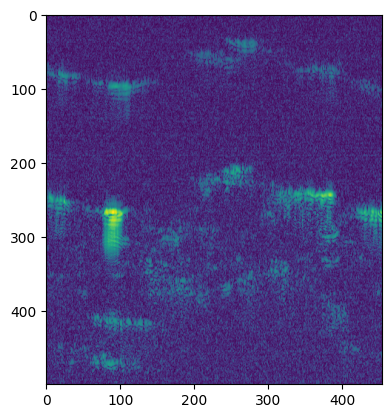

In [131]:
plt.imshow((equalize_adapthist(min_max(pics_without_line[7][200:700]),clip_limit=0.02)))

In [109]:
# arr_crop = ((equalize_adapthist(min_max(pics_without_line[7][200:700]),clip_limit=0.04)))
# kk = top_5_masks(arr_crop)
# window_view = 30
# hole = kk[4]

# rows, cols = arr_crop.shape  
# row_start = max(0, hole[0] - window_view) # Ensure start is not less than 0
# row_end = min(rows, hole[0] + window_view)  # Ensure end is not greater than rows
# col_start = max(0, hole[1] - window_view) # Ensure start is not less than 0
# col_end = min(cols, hole[1] + window_view) # Ensure end is not greater than cols


In [110]:
# plt.imshow(arr_crop[row_start:row_end, col_start:col_end])

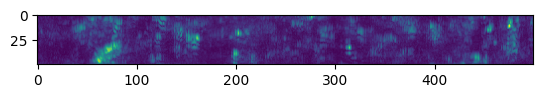

In [ ]:
# plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0)[550:600])

In [ ]:
def top_5_masks(data):
    arr = data.copy()
    top_5_centers = []
    window_remove = 50
    rows, cols = arr.shape  

    for _ in range(3):
        center_max = np.unravel_index(np.argmax(arr), arr.shape)
        top_5_centers.append(center_max)

        row_start = max(0, center_max[0] - window_remove) # Ensure start is not less than 0
        row_end = min(rows, center_max[0] + window_remove)  # Ensure end is not greater than rows
        col_start = max(0, center_max[1] - window_remove) # Ensure start is not less than 0
        col_end = min(cols, center_max[1] + window_remove) # Ensure end is not greater than cols

        arr[row_start:row_end, col_start:col_end] = 0

    return top_5_centers

# def mse_fun_tran(shif,x,y):
#     tform = AffineTransform(translation=(shif[0],0))
#     warped = warp(y, tform,order=1)
#     # warped = fourier_shift(y, (0,shif[0]))
#     return 1-ncc(x,warped)

def mse_fun_tran(shif,x,y):
    # tform = AffineTransform(translation=(shif[0],0))
    warped_x_stat = warp(x, AffineTransform(translation=(-shif[0],0)) ,order=1)
    warped_y_mov = warp(y, AffineTransform(translation=(shif[0],0)) ,order=1)
    # warped = fourier_shift(y, (0,shif[0]))
    return 1-ncc(warped_x_stat,warped_y_mov)

def ants_reg_mapping(stat,mov):
    ants1 = ants.from_numpy(stat.astype(np.float32))
    ants2 = ants.from_numpy(mov.astype(np.float32))
    reg = ants_register(ants1,ants2,type_of_transform = 'Affine')
    return reg['fwdtransforms']

def thresh(data):
    return data*(data>threshold_otsu(data))

def reg_loop(stat_img, mov_img, center_list):
    err_list = []
    transforms = []
    for i in range(len(center_list)):
        center = center_list[i]
        # Define the region of interest around the center
        window_view = 40
        row_start = max(0, center[0] - window_view) # Ensure start is not less than 0
        row_end = min(stat_img.shape[0], center[0] + window_view)  # Ensure end is not greater than rows
        col_start = max(0, center[1] - window_view) # Ensure start is not less than 0
        col_end = min(stat_img.shape[1], center[1] + window_view) # Ensure end is not greater than cols

        # Extract the region of interest
        stat_crop = stat_img[row_start:row_end, col_start:col_end].copy()
        mov_crop = mov_img[row_start:row_end, col_start:col_end].copy()

        temp_tform_manual = AffineTransform(translation=(0,0))
        # Perform registration on the cropped images
        for _ in range(5):
            move = minz(method='powell',fun = mse_fun_tran,x0 =(0),bounds = [(-2,2)],
                        args = (stat_crop
                                ,mov_crop))['x']
            temp_transform = AffineTransform(translation=(move[0]*2,0))
            stat_crop = warp(stat_crop, AffineTransform(translation=(-move[0],0)),order=1)
            mov_crop = warp(mov_crop, AffineTransform(translation=(move[0],0)),order=1)
            # mov_crop = fourier_shift(mov_crop, (0,move[0]))
            # if abs(move[0])<5:
            temp_tform_manual = np.dot(temp_tform_manual,temp_transform)
        warped_mov = warp(mov_img,AffineTransform(translation=((np.array(temp_tform_manual)[0,2])/2,0)),order=1)
        warped_stat = warp(stat_img,AffineTransform(translation=(-(np.array(temp_tform_manual)[0,2])/2,0)),order=1)
        transforms.append(temp_tform_manual)
        err_list.append(1-ncc(warped_stat,warped_mov))
    min_i = np.argmin(np.array(err_list))

    final_transform = extracted_center_reg(center_list[min_i],stat_img,mov_img)

    # return center_list[min_i],transforms[min_i],err_list,transforms
    return final_transform

def extracted_center_reg(center,stat_img,mov_img):
    window_view = 40
    row_start = max(0, center[0] - window_view)
    row_end = min(stat_img.shape[0], center[0] + window_view)
    col_start = max(0, center[1] - window_view)
    col_end = min(stat_img.shape[1], center[1] + window_view)
    temp_tform_manual = AffineTransform(translation=(0,0))

    if center is not None:
        stat_crop = stat_img[row_start:row_end, col_start:col_end].copy()
        mov_crop = mov_img[row_start:row_end, col_start:col_end].copy()
        for _ in range(20):
            move = minz(method='powell',fun = mse_fun_tran,x0 =(0),bounds = [(-2,2)],
                        args = (stat_crop
                                ,mov_crop))['x']
            temp_transform = AffineTransform(translation=(move[0]*2,0))
            stat_crop = warp(stat_crop, AffineTransform(translation=(-move[0],0)),order=1)
            mov_crop = warp(mov_crop, AffineTransform(translation=(move[0],0)),order=1)
            temp_tform_manual = np.dot(temp_tform_manual,temp_transform)

    return temp_tform_manual


transforms_all = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
UP,DOWN = 400,700
all_ncc = []
for i in tqdm(range(5,pics_without_line.shape[0]-1)):
    temp_tform_manual = AffineTransform(translation=(0,0))
    # temp_tform_manual = AffineTransform(translation=(0,0))

    # static = pics_without_line[i][UP:DOWN].copy()
    # temp_moving = pics_without_line[i+1][UP:DOWN].copy()
    static = ((equalize_adapthist(min_max(pics_without_line[i][UP:DOWN]),clip_limit=0.02))).copy()
    temp_moving = ((equalize_adapthist(min_max(pics_without_line[i+1][UP:DOWN]),clip_limit=0.02))).copy()
    # _,tff,_,_ = reg_loop(static,temp_moving,top_5_masks(static))
    tff = reg_loop(static,temp_moving,top_5_masks(static))
    
    # for _ in range(20):
    #     move = minz(method='powell',fun = mse_fun_tran,x0 =(0),bounds = [(-2,2)],
    #                 args = (static
    #                         ,temp_moving))['x']

    #     temp_transform = AffineTransform(translation=(move[0]*2,0))
    #     static = warp(static, AffineTransform(translation=(-move[0],0)),order=1)
    #     temp_moving = warp(temp_moving, AffineTransform(translation=(move[0],0)),order=1)
    #     temp_tform_manual = np.dot(temp_tform_manual,temp_transform)
    temp_tform_manual = AffineTransform(matrix = tff)
    # err = 1-ncc((pics_without_line[i][UP:DOWN])
    #             ,(pics_without_line[i+1][UP:DOWN]))
    # if np.abs(np.array(temp_tform_manual)[0,2])<=1.7:
    transforms_all[i+1:] = np.dot(transforms_all[i+1:],(temp_tform_manual))




100%|██████████| 494/494 [05:05<00:00,  1.62it/s]


In [197]:
static = pics_without_line[170][UP:DOWN].copy()
temp_moving = pics_without_line[171][UP:DOWN].copy()

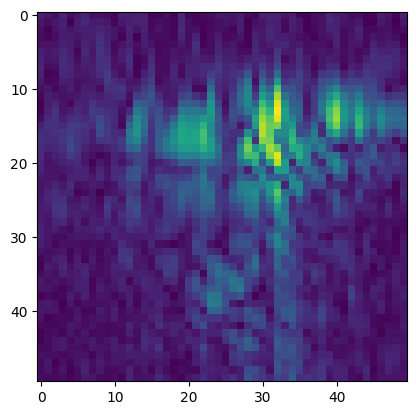

In [200]:
plt.imshow(warp(temp_moving[50:100,100:150],AffineTransform(translation=(0.03,0)),order=3)) 

In [576]:
# # Suppose you want to shift your image by 0.6 pixels vertically and 0.4 pixels horizontally.
# a = np.zeros((10,10))
# b = np.zeros((10,10))
# a[3:5,4:6] = 1
# b[3:5,3:5] = 1
# temp = static[426-20:426+20, 240-20:240+20]

# plt.subplot(1,2,1)
# plt.imshow(temp)

# plt.subplot(1,2,2)
# # plt.imshow(warp(temp,AffineTransform(translation=(-0.5,0)),order=3))
# plt.imshow(fourier_shift(a,(0.4,0)))
# # plt.imshow(warp(a,AffineTransform(translation=(0.3,0)),order=4))

In [31]:
# print(top_5_masks(static))
# reg_loop(static,temp_manual,top_5_masks(static))


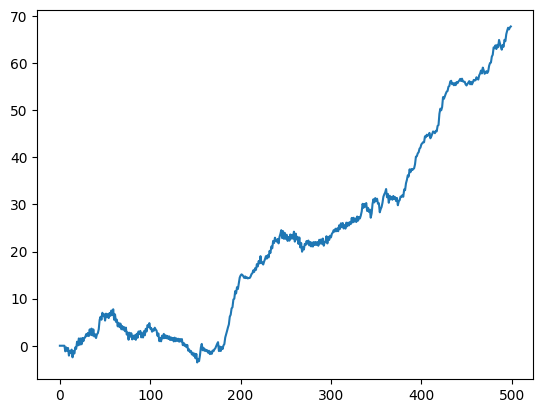

In [216]:
plt.plot(transforms_all[:,0,2])

In [102]:
gg = pics_without_line.copy()
# warp the images
for i in tqdm(range(gg.shape[0])):
    gg[i] = warp(gg[i],AffineTransform(matrix=transforms_all[i]),order=3)


100%|██████████| 500/500 [00:08<00:00, 55.65it/s]


In [103]:
os.makedirs(f'registered/{scan_num}',exist_ok=True)
gg = min_max(gg)
for i,j in tqdm(enumerate(gg)):
    cv2.imwrite(f'registered/{scan_num}/'+f'frame_test{i}.PNG',((j)*((2**8)-1)).astype(np.uint8))

500it [00:02, 198.52it/s]


In [603]:
scan_num = 'pic3'
path = f'{scan_num}/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pic3 = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pic3[i] = dicom.dcmread(path+j).pixel_array
# pics_without_line = pics_without_line.astype(np.float32)

500it [00:01, 447.48it/s]


In [604]:
pic3 = pic3[:,np.r_[350:800],:454]


In [605]:
def ants_reg_mapping(stat,mov):
    ants1 = ants.from_numpy(stat.astype(np.float32))
    ants2 = ants.from_numpy(mov.astype(np.float32))
    reg = ants_register(ants1,ants2,type_of_transform = 'Translation',
                        aff_iterations=(1100, 1200, 500, 500))
    return reg['fwdtransforms']

def ants_all_trans(data,UP,DOWN):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(data.shape[0]-1),desc='tr_all'):
        temp_img = data[i+1][UP:DOWN].copy()
        # PHASE
        coords = phase_cross_correlation((data[i][UP:DOWN][:,:50])
                                        ,(temp_img[:,:50])
                                        ,normalization=None,upsample_factor=15)[0]
        if np.abs(coords[0])<=30:
            # temp_img = warp(temp_img,AffineTransform(translation = (0,-coords[0])),order=0)
            tff = AffineTransform(translation = (0,-coords[0]))
            transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

        # ANTS
        # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN][:,:50]),min_max(temp_img[:,:50]))[0])
        # # mat = scipy.io.loadmat(ants_reg_mapping(min_max(data[i][UP:DOWN]),min_max(data[i+1][UP:DOWN]))[0])
        # if np.abs(mat['AffineTransform_float_2_2'][-2:][0][0])<=5:
        #     tff = AffineTransform(translation = (0,mat['AffineTransform_float_2_2'][-2:][0][0]))
        #     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)
    return transforms_all


mid = 200
UP,DOWN = 20,120
tr_all = ants_all_trans(pic3,UP,DOWN)
for i in tqdm(range(pic3.shape[0]),desc='warping'):
    pic3[i][:mid]  = warp(pic3[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

mid = 200
UP,DOWN = 380,454
tr_all = ants_all_trans(pic3,UP,DOWN)
for i in tqdm(range(pic3.shape[0]),desc='warping'):
    pic3[i][mid:]  = warp(pic3[i][mid:],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 500/500 [00:01<00:00, 266.15it/s]


In [617]:
gg2 = pic3.copy()
# warp the images
for i in tqdm(range(gg2.shape[0])):
    gg2[i] = warp(gg2[i],AffineTransform(matrix=transforms_all[i]).inverse,order=3)


100%|██████████| 500/500 [00:03<00:00, 148.17it/s]


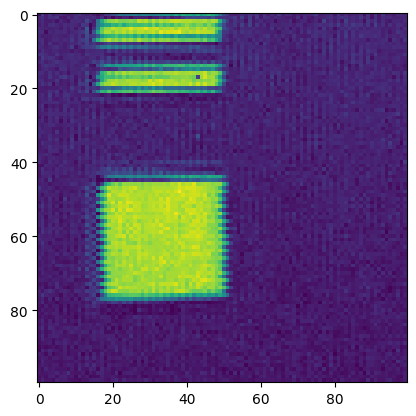

In [618]:
# plt.figure(figsize=(10,10))
plt.imshow((gg2.transpose(1,0,2)[100])[200:300,300:400])

In [40]:
os.makedirs(f'registered/{scan_num}',exist_ok=True)
gg2 = min_max(gg2)
for i,j in tqdm(enumerate(gg2)):
    cv2.imwrite(f'registered/{scan_num}/'+f'frame_test{i}.PNG',((j)*((2**8)-1)).astype(np.uint8))

500it [00:01, 489.00it/s]


# pic3

In [153]:
scan_num = 'pic3'
path = f'{scan_num}/'
pic_paths = []
for i in os.listdir(path):
    if i.endswith('.dcm') or  i.endswith('.DCM') or i.endswith('.PNG'):
        pic_paths.append(i)
pic_paths = np.array(natsorted(pic_paths))
fst = dicom.dcmread(path+pic_paths[0]).pixel_array

pics_without_line = np.empty((len(pic_paths),fst.shape[0],fst.shape[1]))
for i,j in tqdm(enumerate(pic_paths)):
    pics_without_line[i] = dicom.dcmread(path+j).pixel_array
pics_without_line = pics_without_line[5:]

500it [00:01, 417.91it/s]


In [154]:

def mse_fun_tran(shif, x, y , past_shift):
    x = warp(x, AffineTransform(translation=(0,-past_shift)),order=3)
    y = warp(y, AffineTransform(translation=(0,past_shift)),order=3)

    warped_x_stat = warp(x, AffineTransform(translation=(0,-shif[0])),order=3)
    warped_y_mov = warp(y, AffineTransform(translation=(0,shif[0])),order=3)

    return (1-ncc(warped_x_stat ,warped_y_mov))
    
def ants_all_trans(data,UP,DOWN):
    transforms_all = np.tile(np.eye(3),(data.shape[0],1,1))
    for i in tqdm(range(data.shape[0]-1),desc='tr_all'):
        temp_img = data[i+1][UP:DOWN].copy()
        stat = data[i][UP:DOWN].copy()
        # PHASE
        coords = phase_cross_correlation((stat)
                                        ,(temp_img)
                                        ,normalization=None,upsample_factor=20)[0]
        if np.abs(coords[0])<=5:
            temp_img = warp(temp_img,AffineTransform(translation = (0,-coords[0])),order=3)
            tff = AffineTransform(translation = (0,-coords[0]))
            transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)

        # MANUAL
        # temp_tform_manual = AffineTransform(translation=(0,0))
        temp_manual = temp_img.copy()
        past_shift = 0
        for _ in range(5):
            move = minz(method='L-BFGS-B',fun = mse_fun_tran,x0 =(0), bounds=[(-2,2)],
                        args = (stat
                                ,temp_manual
                                ,past_shift))['x']

            past_shift += move[0]
        temp_tform_manual = AffineTransform(matrix = AffineTransform(translation=(0,past_shift*2)))
        transforms_all[i+1:] = np.dot(transforms_all[i+1:],temp_tform_manual)

    return transforms_all


In [155]:
pics_without_line = pics_without_line[:,np.r_[350:800]]

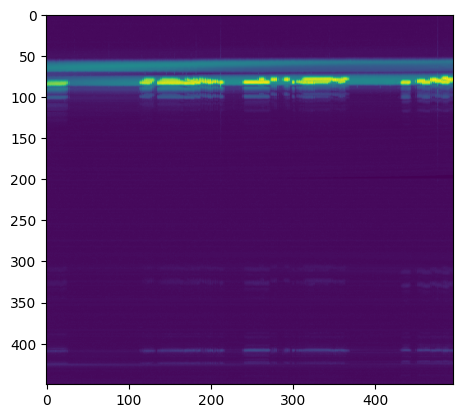

In [160]:
plt.imshow(np.max(pics_without_line.transpose(2,1,0),axis=0))

In [157]:
mid = 200
UP,DOWN = 20,120
tr_all = ants_all_trans(pics_without_line,UP,DOWN)
for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
    pics_without_line[i][:mid]  = warp(pics_without_line[i][:mid],AffineTransform(matrix=tr_all[i]),order=3)

warping: 100%|██████████| 495/495 [00:03<00:00, 135.67it/s]


In [112]:
# mid = 200
# UP,DOWN = 380,454
# tr_all = ants_all_trans(pics_without_line,UP,DOWN)
# for i in tqdm(range(pics_without_line.shape[0]),desc='warping'):
#     pics_without_line[i][mid:]  = warp(pics_without_line[i][mid:],AffineTransform(matrix=tr_all[i]),order=3)

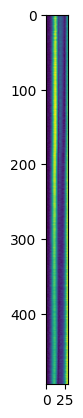

In [158]:
plt.imshow(pics_without_line[:,:,100][:,50:80])

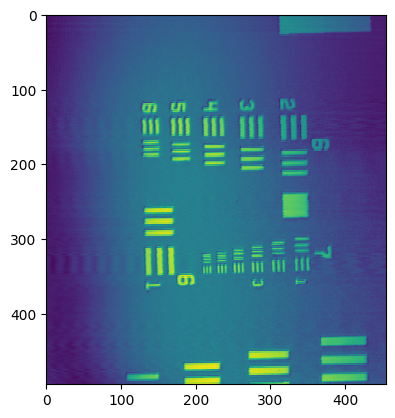

In [159]:
plt.imshow(pics_without_line[:,80,:])

In [195]:
temp_img = pics_without_line[:,80,:].copy()

# temp_img = cv2.imread('AVG_Reslice XY original_enface.png',cv2.IMREAD_UNCHANGED)
# tp = fft2(temp_img).flatten()
# tp[tp.shape[0]//2:] = 0
# tp = np.where(np.abs(tp)>0.25,tp,0)
# temp_img = ifft2(tp.reshape(temp_img.shape)).real

In [196]:
def shift_func(shif, x, y , past_shift):
    x = scp.shift(x, -past_shift,order=3,mode='nearest')
    y = scp.shift(y, past_shift,order=3,mode='nearest')

    warped_x_stat = scp.shift(x, -shif[0],order=3,mode='nearest')
    warped_y_mov = scp.shift(y, shif[0],order=3,mode='nearest')

    return (1-ncc1d(warped_x_stat ,warped_y_mov))

def ncc1d(array1, array2):
    correlation = np.correlate(array1, array2, mode='valid')
    array1_norm = np.linalg.norm(array1)
    array2_norm = np.linalg.norm(array2)
    if array1_norm == 0 or array2_norm == 0:
        return np.zeros_like(correlation)
    normalized_correlation = correlation / (array1_norm * array2_norm)
    return normalized_correlation
    
def denoise_signal(errs , rows = 10):
    rows = max(0, rows)
    kk = fft(errs)
    kk[int(rows):] = 0
    kk = abs(ifft(kk))
    return kk

In [197]:
sf = [0]
for i in tqdm(range(temp_img.shape[0]-1)):
        # st = denoise_signal(temp_img[i],rows=5000)
        # # # mv = match_histograms(scp.median_filter(temp_img[i+1],size=3),st)
        # mv = denoise_signal(temp_img[i+1],rows=50)
        # grad_feat = np.argmax(np.abs(np.gradient(temp_img[i])[5:-5]))+5
        # # print(grad_feat,i)
        # grad_feat = max(20,grad_feat)
        # grad_feat = min(grad_feat,temp_img.shape[1]-20)

        # st = temp_img[i][grad_feat-20:grad_feat+20]
        # mv = temp_img[i+1][grad_feat-20:grad_feat+20]


        st = temp_img[i]
        mv = temp_img[i+1]
        rt = 0
        past_shift = 0
        # rt = phase_cross_correlation(st,mv,upsample_factor=100,disambiguate=True)[0][0]
        for _ in range(5):
                move = minz(method='nelder-mead',fun = shift_func,x0 =(0),bounds = ([(-3,3)]),
                        args = ((st)
                                ,(mv)
                                ,past_shift))['x']
                # print(move)

                past_shift += move[0]
                rt+=move[0]
        # if abs(rt*2)<5:
        sf.append(rt*2)

100%|██████████| 494/494 [00:34<00:00, 14.41it/s]


In [198]:
sf = np.array(sf)
# for i in range(1,sf.shape[0]):
#     sf[i] += sf[i-1]

for i in tqdm(range(1,len(sf),2)):
    temp_img[i] = scp.shift(temp_img[i],shift = sf[i],order=3,mode='nearest')

100%|██████████| 247/247 [00:00<00:00, 10478.55it/s]


In [152]:
grad_feat = np.argmax(np.abs(np.gradient((temp_img[208]))[5:-5]))+5
grad_feat

260

In [192]:
from scipy.signal import find_peaks

In [196]:
find_peaks(denoise_signal(temp_img[209],rows=10))

(array([ 43,  90, 136, 180, 227, 271, 333, 394, 437]), {})

In [260]:
grad_feat = np.argmax(np.abs(np.gradient(temp_img[202])[5:-5]))+5
# print(grad_feat,i)
grad_feat = max(20,grad_feat)
grad_feat = min(grad_feat,temp_img.shape[1]-20)

st = temp_img[202][grad_feat-20:grad_feat+20]
mv = temp_img[202+1][grad_feat-20:grad_feat+20]

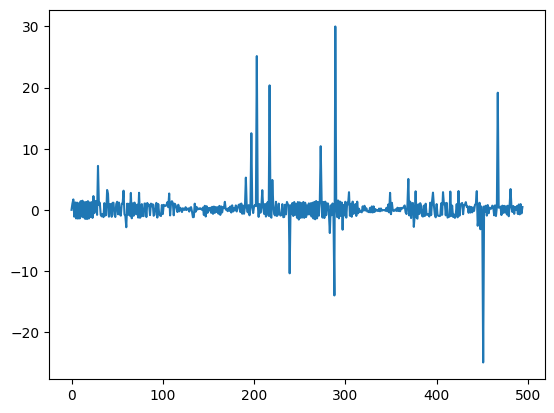

In [199]:
plt.plot(sf)

In [224]:
# # temp_img = pics_without_line[:,90,:].copy()
# temp_img = pics_without_line[:,90,:].copy()
# for i in range(len(sf)):
#     temp_img[i] = scp.shift(temp_img[i],sf[i])

# # moves = [-0.73,0.73]*temp_img.shape[0]
# # for i in range(temp_img.shape[0]-1):
# #      temp_img[i+1] = scp.shift(temp_img[i+1],moves[i],order=3)

In [ ]:
# cv2.imwrite('newodd_frames_registered.PNG',temp_img)

True

In [192]:
# temp_img = cv2.imread('AVG_Reslice XY original_enface.png',cv2.IMREAD_UNCHANGED)
# reg_img = cv2.imread('odd_frames_registered.PNG',cv2.IMREAD_UNCHANGED)

In [193]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.patches import Rectangle
# from matplotlib.patches import ConnectionPatch

# def display_images_with_zooms(img1, img2, zoomed_imgs, zoom_locations=None, figsize=(12, 10), titles=None):
#     """
#     Display two original images side by side with their corresponding zoomed regions below.
    
#     Parameters:
#     -----------
#     img1, img2 : 2D numpy arrays
#         Original grayscale images
        
#     zoomed_imgs : list of 4 2D numpy arrays
#         Four zoomed images in the order [zoom1_img1, zoom1_img2, zoom2_img1, zoom2_img2]
#         Where zoom1_img1 is the first zoomed region from img1,
#               zoom1_img2 is the first zoomed region from img2,
#               zoom2_img1 is the second zoomed region from img1,
#               zoom2_img2 is the second zoomed region from img2
              
#     zoom_locations : list of 4 tuples, optional
#         Locations of zoom regions in the original images: [(y1, y2, x1, x2), ...] 
#         If provided, rectangles will be drawn on the original images
        
#     figsize : tuple, optional
#         Figure size
        
#     titles : list of 6 strings, optional
#         Titles for all subplots [img1_title, img2_title, zoom1_img1_title, ...]
        
#     Returns:
#     --------
#     fig : matplotlib figure
#     """
#     # Create figure and grid of subplots
#     fig = plt.figure(figsize=figsize,tight_layout=True)

#     # Define grid with 3 rows (2 for zoomed regions) and 2 columns
#     gs = fig.add_gridspec(3, 2, height_ratios=[3, 1.5, 1.5])
    
#     # Default titles if not provided
#     if titles is None:
#         titles = ["Image 1", "Image 2", 
#                   "Zoom Region 1 (Image 1)", "Zoom Region 1 (Image 2)",
#                   "Zoom Region 2 (Image 1)", "Zoom Region 2 (Image 2)"]
    
#     # Plot original images in the top row
#     ax1 = fig.add_subplot(gs[0, 0])
#     ax1.imshow(img1, cmap='gray')
#     ax1.set_title(titles[0])
#     ax1.set_axis_off()
    
#     ax2 = fig.add_subplot(gs[0, 1])
#     ax2.imshow(img2, cmap='gray')
#     ax2.set_title(titles[1])
#     ax2.set_axis_off()
    
#     # Plot zoomed regions in the bottom rows
#     # First zoom region (in second row)
#     ax3 = fig.add_subplot(gs[1, 0])
#     ax3.imshow(zoomed_imgs[0], cmap='gray')
#     ax3.set_title(titles[2])
#     ax3.set_axis_off()
    
#     ax4 = fig.add_subplot(gs[1, 1])
#     ax4.imshow(zoomed_imgs[1], cmap='gray')
#     ax4.set_title(titles[3])
#     ax4.set_axis_off()

    
#     # Second zoom region (in third row)
#     ax5 = fig.add_subplot(gs[2, 0])
#     ax5.imshow(zoomed_imgs[2], cmap='gray')
#     ax5.set_title(titles[4])
#     ax5.set_axis_off()
    
#     ax6 = fig.add_subplot(gs[2, 1])
#     ax6.imshow(zoomed_imgs[3], cmap='gray')
#     ax6.set_title(titles[5])
#     ax6.set_axis_off()
    
#     # If zoom locations are provided, draw rectangles on original images
#     if zoom_locations is not None:
#         colors = ['red', 'green']
        
#         # Add rectangles for the first zoom region (red)
#         rect1 = Rectangle((zoom_locations[0][2], zoom_locations[0][0]), 
#                           zoom_locations[0][3]-zoom_locations[0][2], 
#                           zoom_locations[0][1]-zoom_locations[0][0], 
#                           linewidth=2, edgecolor=colors[0], facecolor='none')
#         ax1.add_patch(rect1)
    
        
#         rect2 = Rectangle((zoom_locations[1][2], zoom_locations[1][0]), 
#                           zoom_locations[1][3]-zoom_locations[1][2], 
#                           zoom_locations[1][1]-zoom_locations[1][0], 
#                           linewidth=2, edgecolor=colors[0], facecolor='none')
#         ax2.add_patch(rect2)
        
#         # Add rectangles for the second zoom region (green)
#         rect3 = Rectangle((zoom_locations[2][2], zoom_locations[2][0]), 
#                           zoom_locations[2][3]-zoom_locations[2][2], 
#                           zoom_locations[2][1]-zoom_locations[2][0], 
#                           linewidth=2, edgecolor=colors[1], facecolor='none')
#         ax1.add_patch(rect3)
        
#         rect4 = Rectangle((zoom_locations[3][2], zoom_locations[3][0]), 
#                           zoom_locations[3][3]-zoom_locations[3][2], 
#                           zoom_locations[3][1]-zoom_locations[3][0], 
#                           linewidth=2, edgecolor=colors[1], facecolor='none')
#         ax2.add_patch(rect4)
        
#         # Optional: Add connection lines between original images and zoomed regions
#         # First zoom region connections (red)
#         con1 = ConnectionPatch(
#             xyA=(zoom_locations[0][2], zoom_locations[0][0]), coordsA=ax1.transData,
#             xyB=(0, 0), coordsB=ax3.transAxes,
#             arrowstyle="-", linestyle="--", color=colors[0], alpha=0.6)
#         fig.add_artist(con1)
        
#         con2 = ConnectionPatch(
#             xyA=(zoom_locations[1][2], zoom_locations[1][0]), coordsA=ax2.transData,
#             xyB=(0, 0), coordsB=ax4.transAxes,
#             arrowstyle="-", linestyle="--", color=colors[0], alpha=0.6)
#         fig.add_artist(con2)
        
#         # Second zoom region connections (green)
#         con3 = ConnectionPatch(
#             xyA=(zoom_locations[2][2], zoom_locations[2][0]), coordsA=ax1.transData,
#             xyB=(0, 0), coordsB=ax5.transAxes,
#             arrowstyle="-", linestyle="--", color=colors[1], alpha=0.6)
#         fig.add_artist(con3)
        
#         con4 = ConnectionPatch(
#             xyA=(zoom_locations[3][2], zoom_locations[3][0]), coordsA=ax2.transData,
#             xyB=(0, 0), coordsB=ax6.transAxes,
#             arrowstyle="-", linestyle="--", color=colors[1], alpha=0.6)
#         fig.add_artist(con4)
    
#     plt.tight_layout()
#     return fig

# # Example usage
# if __name__ == "__main__":
#     # Create sample original images
#     # size = 200
#     img1 = temp_img
#     img2 = reg_img
    
#     # Add some features to original images
#     # xx, yy = np.meshgrid(np.linspace(0, 1, size), np.linspace(0, 1, size))
#     # img1 = np.sin(xx*10) * np.cos(yy*10) * 0.5 + 0.5
#     # img2 = np.cos(xx*10) * np.sin(yy*10) * 0.5 + 0.5
    
#     # Define two regions to "zoom" into
#     region1_y1, region1_y2, region1_x1, region1_x2 = 90, 150,300,350
#     region2_y1, region2_y2, region2_x1, region2_x2 = 150,220,200,300
    
#     # Create zoomed images (these would normally be your pre-zoomed images)
#     zoom1_img1 = img1[region1_y1:region1_y2, region1_x1:region1_x2]
#     zoom1_img2 = img2[region1_y1:region1_y2, region1_x1:region1_x2]
#     zoom2_img1 = img1[region2_y1:region2_y2, region2_x1:region2_x2]
#     zoom2_img2 = img2[region2_y1:region2_y2, region2_x1:region2_x2]
    
#     # Collect zoomed images
#     zoomed_imgs = [zoom1_img1, zoom1_img2, zoom2_img1, zoom2_img2]
    
#     # Optional: Define zoom locations for drawing rectangles
#     zoom_locations = [
#         (region1_y1, region1_y2, region1_x1, region1_x2),  # Region 1 in img1
#         (region1_y1, region1_y2, region1_x1, region1_x2),  # Region 1 in img2
#         (region2_y1, region2_y2, region2_x1, region2_x2),  # Region 2 in img1
#         (region2_y1, region2_y2, region2_x1, region2_x2)   # Region 2 in img2
#     ]
    
#     # Custom titles
#     titles = [
#         "Original Image", "Registered Image",
#         "", "",
#         "", ""
#     ]
    
#     # Display images
#     fig = display_images_with_zooms(
#         img1, img2, zoomed_imgs, 
#         zoom_locations=zoom_locations,
#         titles=titles
#     )
    
#     plt.savefig('multi_image_comparison.png', dpi=500, bbox_inches='tight')
#     plt.show()
    
#     # # Example of usage without zoom locations (no rectangles or connection lines)
#     # fig = display_images_with_zooms(
#     #     img1, img2, zoomed_imgs, 
#     #     zoom_locations=None,
#     #     titles=titles
#     # )
    
#     # # plt.savefig('multi_image_comparison_no_rectangles.png', dpi=150, bbox_inches='tight')
#     # plt.show()

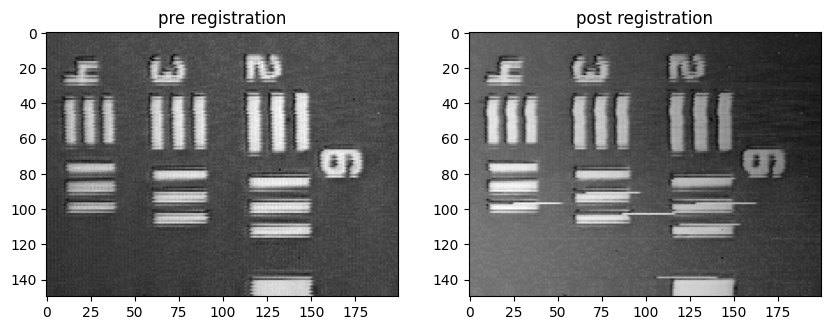

In [200]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.title('pre registration')
plt.imshow(pics_without_line[:,90,:][100:250,200:400],cmap='gray')

plt.subplot(1,2,2)
plt.title('post registration')
plt.imshow(temp_img[100:250,200:400],cmap='gray')

In [191]:
gg = pics_without_line.copy()
for i in tqdm(range(len(kk))):
    gg[i+1] = scp.shift(gg[i+1],shift = (0,kk[i][0]))

100%|██████████| 499/499 [00:09<00:00, 52.94it/s]


In [195]:
os.makedirs(f'registered/{scan_num}',exist_ok=True)
gg = min_max(gg)
for i,j in tqdm(enumerate(gg)):
    cv2.imwrite(f'registered/{scan_num}/'+f'frame_test{i}.PNG',((j)*((2**8)-1)).astype(np.uint8))

500it [00:00, 515.63it/s]


In [38]:
def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(shif[0],shif[1]))
    warped = warp(y, tform,order=3)
    return 1-ncc(x,warped)

def ants_reg_mapping(stat,mov):
    ants1 = ants.from_numpy(stat.astype(np.float32))
    ants2 = ants.from_numpy(mov.astype(np.float32))
    reg = ants_register(ants1,ants2,type_of_transform = 'Translation')
    return reg['fwdtransforms']

def thresh(data):
    return data*(data>threshold_otsu(data))

transforms_all = np.tile(np.eye(3),(pics_without_line.shape[0],1,1))
UP,DOWN = 50,100
all_ncc = []
for i in tqdm(range(5,pics_without_line.shape[0]-1)):
    # coords = phase_cross_correlation(thresh(pics_without_line[i][UP:DOWN])
    #                                 ,thresh(pics_without_line[i+1][UP:DOWN])
    #                                 ,normalization=None,upsample_factor=15)
    # tff = AffineTransform(translation = (-coords[0][1],0))
    # err = 1-ncc((pics_without_line[i][UP:DOWN])
    #             ,(pics_without_line[i+1][UP:DOWN]))
    # # err = coords[1]
    # if np.abs(coords[0][1])<2:
    #     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)
    # all_ncc.append(err)

    temp_tform_manual = AffineTransform(translation=(0,0))
    temp_manual = pics_without_line[i+1][UP:DOWN].copy()
    for _ in range(50):
        move = minz(method='powell',fun = mse_fun_tran,x0 =(0,0),
                    args = ((pics_without_line[i][UP:DOWN])
                            ,(temp_manual)))['x']
        temp_transform = AffineTransform(translation=(move[0],move[1]))
        temp_manual = warp(temp_manual, temp_transform,order=3)
        temp_tform_manual = np.dot(temp_tform_manual,temp_transform)
    temp_tform_manual = AffineTransform(matrix = temp_tform_manual)
    # err = 1-ncc((pics_without_line[i][UP:DOWN])
    #             ,(pics_without_line[i+1][UP:DOWN]))
    if np.abs(np.array(temp_tform_manual)[0,2])<=2:
        # temp_img = warp(temp_img,temp_tform_manual,order=3)
        transforms_all[i+1:] = np.dot(transforms_all[i+1:],temp_tform_manual)
    # all_ncc.append(err)

    # mat = scipy.io.loadmat(ants_reg_mapping((pics_without_line[i][UP:DOWN])
    #                                         ,(pics_without_line[i+1][UP:DOWN]))[0])
    # tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],0))

    # err = 1-ncc((pics_without_line[i][np.r_[UP:DOWN]])
    #                     ,(warp(pics_without_line[i+1][np.r_[UP:DOWN]], tff,order=3)))
    # if err<0.006:
    #     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)
    # all_ncc.append(err)

    # temp_tform_manual = AffineTransform(translation=(0,0)).params
    # temp_manual = pics_without_line[i+1][UP:DOWN].copy()
    # for _ in range(20):
    #     mat = scipy.io.loadmat(ants_reg_mapping((pics_without_line[i][UP:DOWN])
    #                                             ,(temp_manual))[0])
    #     # tff = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],0))
    #     temp_transform = AffineTransform(translation = (mat['AffineTransform_float_2_2'][-2:][1,0],0))
    #     temp_manual = warp(temp_manual, temp_transform,order=3)
    #     temp_tform_manual = np.dot(temp_tform_manual, temp_transform.params)
    # tff = AffineTransform(matrix = temp_tform_manual)

    # err = 1-ncc((pics_without_line[i][np.r_[UP:DOWN]])
    #             ,(warp(pics_without_line[i+1][np.r_[UP:DOWN]], tff,order=3)))
    # if np.abs(tff.params[0,2])<=2:
    #     transforms_all[i+1:] = np.dot(transforms_all[i+1:],tff)



100%|██████████| 494/494 [14:27<00:00,  1.76s/it]


In [39]:
gg = pics_without_line.copy()
# warp the images
for i in tqdm(range(gg.shape[0])):
    gg[i] = warp(gg[i],AffineTransform(matrix=transforms_all[i]),order=3)


100%|██████████| 500/500 [00:03<00:00, 153.68it/s]


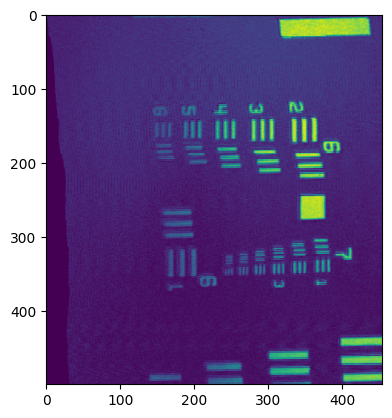

In [40]:
plt.imshow((gg.transpose(1,0,2)[100]))

In [24]:
os.makedirs(f'registered/{scan_num}',exist_ok=True)
gg = min_max(gg)
for i,j in tqdm(enumerate(gg)):
    cv2.imwrite(f'registered/{scan_num}/'+f'frame_test{i}.PNG',((j)*((2**16)-1)).astype(np.uint16))

500it [00:01, 251.00it/s]


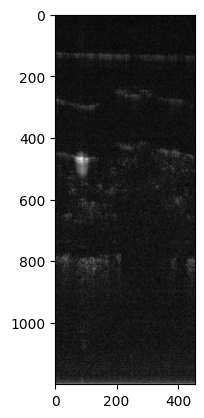

In [66]:
plt.imshow(equalize_adapthist(min_max(pics_without_line[20]),clip_limit=0.02),cmap='gray')

In [81]:
def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(shif[0],0))
    warped = warp(y, tform,order=3)
    return 1-ncc(x,warped)

In [ ]:
k = (min_max(pics_without_line[20][400:800]))
temp = warp(k,AffineTransform(translation=(1,0)),order=0)
temp_tff = AffineTransform(translation = (0,0))
init_move = 0
for _ in tqdm(range(2)):
        move = minz(method='powell',fun = mse_fun_tran,x0 =(0),
                        args = (k,
                                temp
                                ))['x']

        # move = dual_annealing(func = mse_fun_tran,
        #         bounds = [(-10,10)],
        #         args = (k,temp))['x']

        # mat = scipy.io.loadmat(ants_reg_mapping(k
        #                                 ,temp)[0])
        # move = [mat['AffineTransform_float_2_2'][-2:][1][0]]
        temp = warp(temp,AffineTransform(translation = (move[0],0)),order=3)
        init_move = move[0]
        temp_tff = np.dot(temp_tff,AffineTransform(translation = (move[0],0)))



100%|██████████| 2/2 [00:00<00:00,  2.83it/s]


In [151]:
mat = scipy.io.loadmat(ants_reg_mapping(k
                                ,temp)[0])
[mat['AffineTransform_float_2_2'][-2:][1][0]]

[0.003250122]

In [152]:
phase_cross_correlation(k,temp,normalization=None,upsample_factor=15)[0]

array([0., 0.], dtype=float32)

In [153]:
temp_tff

array([[ 1.        ,  0.        , -0.99335738],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [60]:
def mse_fun_tran(shif,x,y):
    tform = AffineTransform(translation=(shif[0],0))
    warped = warp(y, tform,order=3)
    return 1-ncc(x,warped)

In [61]:
k = equalize_adapthist(min_max(pics_without_line[20][400:800]))

In [72]:
dual_annealing(func = mse_fun_tran,
                bounds = [(-30,30)],
                args = (k
                        ,warp(k,AffineTransform(translation=(0.4,0)))
                        ))['x']

array([-0.27999511])

In [71]:
minz(method='powell',fun = mse_fun_tran,x0 =(0),
                        args = (k,
                                warp(k,AffineTransform(translation=(0.4,0)))
                                ))['x']

array([-0.27996093])

In [37]:
dual_annealing(func = mse_fun_tran,
                bounds = [(-10,10)],
                args = (equalize_adapthist(min_max(pics_without_line[20]),clip_limit=0.02)[400:800]
                        ,equalize_adapthist(min_max(pics_without_line[21]),clip_limit=0.02)[400:800]))['x']

array([1.47603484])

In [244]:
mat = scipy.io.loadmat(ants_reg_mapping(equalize_adapthist(min_max(pics_without_line[20]),clip_limit=0.02)[400:800]
                                        ,equalize_adapthist(min_max(pics_without_line[21]),clip_limit=0.02)[400:800])[0])
(mat['AffineTransform_float_2_2'][-2:][1][0])

-0.6014557

-0.3553009